### In this notebook we will build a multi-layer perceptron and SVM model for the dataset

<h3>Student Name : Laxman Kumar<br> Subject Name : IST 718 Big Data Analysis <br> University : Syracuse University <br> Professor : Prof Willard E Williamson</h3>

## Utility Function

In [1]:
# Do not delete or change this cell
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:return True
    else:return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then constructed based on the runtime env.
# Params data_file_name: The base name of the data file to load 
# Returns the full path file name based on the runtime env

def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():full_path_name = "/FileStore/tables/%s" % data_file_name
        # build the full path file name assuming data brick env
    # else the data is assumed to be in the same dir as this notebook
    else:full_path_name = data_file_name
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
    # return the full path file name to the caller
    return full_path_name

## Libraries

In [2]:
import findspark
findspark.init()

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import seaborn as sns
%matplotlib inline

In [7]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row,SQLContext,SparkSession
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline,feature,regression
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import isnan, isnull, when, count, col,expr
from pyspark.sql.types import StructField, StructType, StringType, LongType,IntegerType,StringType
from pyspark.sql import functions as fn
from pyspark.sql.functions import *

In [8]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Data Loading

Reading cleaned csv into df using pyspark spark read function 

In [9]:
df = spark.read.format("csv").load(get_training_filename("data/hospital_readmission_cleaned.csv"),
                                   header=True,inferSchema=True)

### Function for making confusion matrix

Below function is used for building confusion matrix plot using matplotlib library. The function takes confusion matrix, title and normalize as input parameter. 

In [10]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),horizontalalignment="center",fontsize=14,color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),horizontalalignment="center",fontsize=14,color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Building a SVM Model

### Converting categorical variables into numerical

### Defining the list of all categorical column and numerical column. Also defining string indexer object  and Onehot encoder object.

In [42]:
#List of all categorical feature columns
categorical_columns= ['race','diag_1','diag_2','diag_3','admission_type_name','dischage_disposition_name',
                      'admission_source_name','gender','age','max_glu_serum','insulin','change','diabetesMed']

#List of all numerical feature column
numerical_columns = [ 'num_lab_procedures','num_medications','number_outpatient','number_emergency',
                      'number_inpatient','number_diagnoses']

# The index of string vlaues multiple columns
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_columns]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,
                          inputCol=indexer.getOutputCol(),
                          outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

### Making a pipeline and  fitting a pipeline, also using the fitted pipeline model to transform the data

In [43]:
#Piepline to fit string indexer and One hot encoders
pipeline = Pipeline(stages=indexers+encoders)
model=pipeline.fit(df)

#Creating new df using tranform of pipeline model
hosp_readmit_df2 = model.transform(df)

In [44]:
#Making a list of all the converted categorical columns 
assembler_inputs = [feature + "_indexed_encoded" for feature in categorical_columns] 

#List of all the columns of converted categorical columns and numerical columns
allColumns = assembler_inputs+numerical_columns

### Tranforming all the column using vector assembler. 

In [45]:
#Making a vector assembler object
assembler = VectorAssembler(inputCols=allColumns, outputCol="assembled_inputs") 

#Making a pipeline and using fitted pipeline model to transform the one hot encoded vector.
pipe = Pipeline(stages=[assembler]).fit(hosp_readmit_df2)
hosp_readmit__df = pipe.transform(hosp_readmit_df2).select('assembled_inputs','readmitted')

### Splitting training and testing data

In [46]:
train_data, test_data = hosp_readmit__df.randomSplit([.8, .2],seed=1234)

### Making a Linear SVM object

In [47]:
#Making a linear svm object
svm = LinearSVC(maxIter=1500, regParam=0.01,featuresCol='assembled_inputs', labelCol='readmitted')

#making a pipeline with svm object
pipe = Pipeline(stages=[svm]).fit(train_data)

### Using binary classification evaluator to calculate the AUC score

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator(labelCol='readmitted')
bce.evaluate(pipe.transform(test_data))  

0.6839526702634386

### Predicting readmission for test data

In [49]:
test_data_predicted = pipe.transform(test_data).select('readmitted',fn.col('prediction').cast('int').alias('prediction'))

### Generating a classfication report

In [50]:
y_true = test_data_predicted.select(['readmitted']).collect()
y_pred = test_data_predicted.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.78      0.69     10874
           1       0.64      0.47      0.54      9428

    accuracy                           0.63     20302
   macro avg       0.64      0.62      0.62     20302
weighted avg       0.64      0.63      0.62     20302



### Making a confusion matrix plot

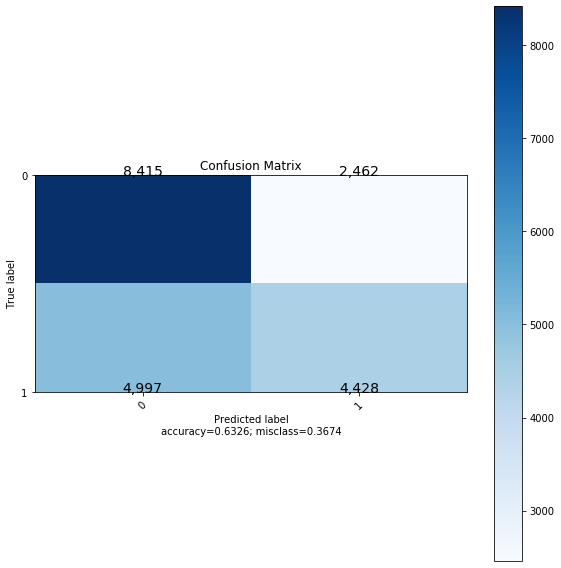

In [32]:
cm =confusion_matrix(y_true, y_pred)
cm2_3 = confusion_matrix(y_pred=y_pred, y_true=y_true)
plot_confusion_matrix(cm           = cm2_3, 
                      normalize    = False,
                      target_names = ["0","1"],
                      title        = "Confusion Matrix")

# Bulding multilayer perceptron

### Converting categorical variables into numerical

### Defining the list of all categorical column and numerical column. Also defining string indexer object  and Onehot encoder object.

In [61]:
#List of all categorical feature columns
categorical_columns= ['race','diag_1','diag_2','admission_type_name','dischage_disposition_name',
                      'admission_source_name','gender','age','insulin','change','diabetesMed']

#List of all numerical feature column
numerical_columns = [ 'num_medications','number_emergency','number_inpatient','number_diagnoses']


# The index of string vlaues multiple columns
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_columns]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,
                          inputCol=indexer.getOutputCol(),
                          outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

### Making a pipeline and  fitting a pipeline, also using the fitted pipeline model to transform the data

In [62]:
#Piepline to fit string indexer and One hot encoders
pipeline = Pipeline(stages=indexers+encoders)
model=pipeline.fit(df)

#Creating new df using tranform of pipeline model
hosp_readmit_df2 = model.transform(df)

In [63]:
#Making a list of all the converted categorical columns 
assembler_inputs = [feature + "_indexed_encoded" for feature in categorical_columns] 

#List of all the columns of converted categorical columns and numerical columns
allColumns = assembler_inputs+numerical_columns

### Tranforming all the column using vector assembler. 

In [64]:
#Making a vector assembler object
assembler = VectorAssembler(inputCols=allColumns, outputCol="assembled_inputs") 

#Making a pipeline and using fitted pipeline model to transform the one hot encoded vector.
pipe = Pipeline(stages=[assembler]).fit(hosp_readmit_df2)
hosp_readmit__df = pipe.transform(hosp_readmit_df2).select('assembled_inputs','readmitted')

### Splitting training and testing data

In [74]:
train_data, test_data = hosp_readmit__df.randomSplit([.7, .3],seed=1234)

In [75]:
train_data.toPandas()['assembled_inputs'][0]

SparseVector(1541, {0: 1.0, 5: 1.0, 721: 1.0, 1469: 1.0, 1476: 1.0, 1500: 1.0, 1517: 1.0, 1519: 1.0, 1530: 1.0, 1533: 1.0, 1535: 1.0, 1537: 21.0, 1539: 1.0, 1540: 9.0})

### Making a Multilayer perceptron model

In [76]:
from pyspark.ml import classification
mlp2 = classification.MultilayerPerceptronClassifier(seed=0,labelCol='readmitted',stepSize=0.05,blockSize=64).\
                                   setMaxIter(100).setFeaturesCol('assembled_inputs').setLayers([1*1541, 256, 2])

mlp2_model = Pipeline(stages=[mlp2]).fit(train_data)

In [77]:
mlp2_model.stages[0].transform(train_data).show(10)

+--------------------+----------+--------------------+--------------------+----------+
|    assembled_inputs|readmitted|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+----------+
|(1541,[0,5,721,14...|         0|[-0.0920034569924...|[0.32442227265922...|       1.0|
|(1541,[0,5,721,14...|         1|[0.09914172075033...|[0.39498269787421...|       1.0|
|(1541,[0,5,721,14...|         1|[0.07877681173008...|[0.43858759939726...|       1.0|
|(1541,[0,5,721,14...|         1|[-0.0890556717479...|[0.32799559854499...|       1.0|
|(1541,[0,5,721,14...|         0|[0.10374404495847...|[0.44450768392042...|       1.0|
|(1541,[0,5,721,14...|         0|[0.23330765285436...|[0.48448420671323...|       1.0|
|(1541,[0,5,721,14...|         0|[-0.0675176389199...|[0.39438870543029...|       1.0|
|(1541,[0,5,721,14...|         0|[0.14894739460638...|[0.42415862565735...|       1.0|
|(1541,[0,5,721,14...|         1|[-0.246803

### Using binary classification evaluator to calculate the AUC score

In [78]:
from pyspark.ml import evaluation
evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy",labelCol='readmitted')

In [79]:
evaluator.evaluate(mlp2_model.transform(test_data))

0.6371478988301418

### Predicting readmission for test data

In [80]:
test_data_predicted = mlp2_model.transform(test_data).select('readmitted',fn.col('prediction').cast('int').alias('prediction'))

### Generating a classfication report

In [81]:
y_true = test_data_predicted.select(['readmitted']).collect()
y_pred = test_data_predicted.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68     16511
           1       0.63      0.53      0.57     14091

    accuracy                           0.64     30602
   macro avg       0.63      0.63      0.63     30602
weighted avg       0.64      0.64      0.63     30602



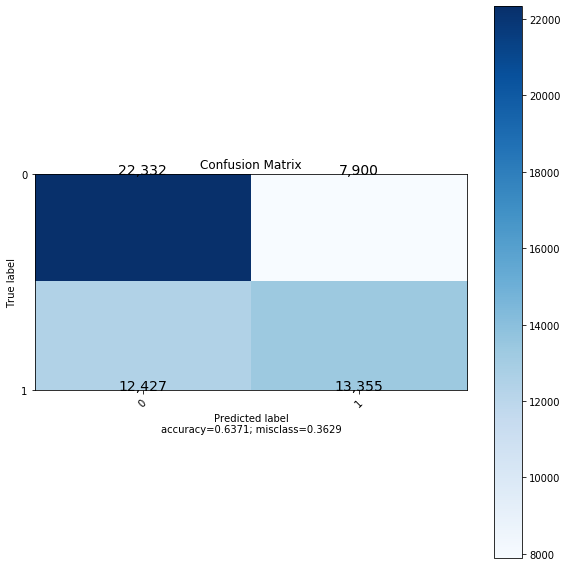

In [73]:
from sklearn.metrics import confusion_matrix
cm =confusion_matrix(y_true, y_pred)
cm2_3 = confusion_matrix(y_pred=y_pred, y_true=y_true)
plot_confusion_matrix(cm           = cm2_3, 
                      normalize    = False,
                      target_names = ["0","1"],
                      title        = "Confusion Matrix")